## Dataset Description

The dataset contains California housing information. Each row represents a district.

- **Features(x):**
  - Median Income
  - Median Age
  - Total Rooms
  - Total Bedrooms
  - Population
  - Households
  - Latitude
  - Longitude
- **Target Variable(Y):**
  - Median House Value


## Load Data


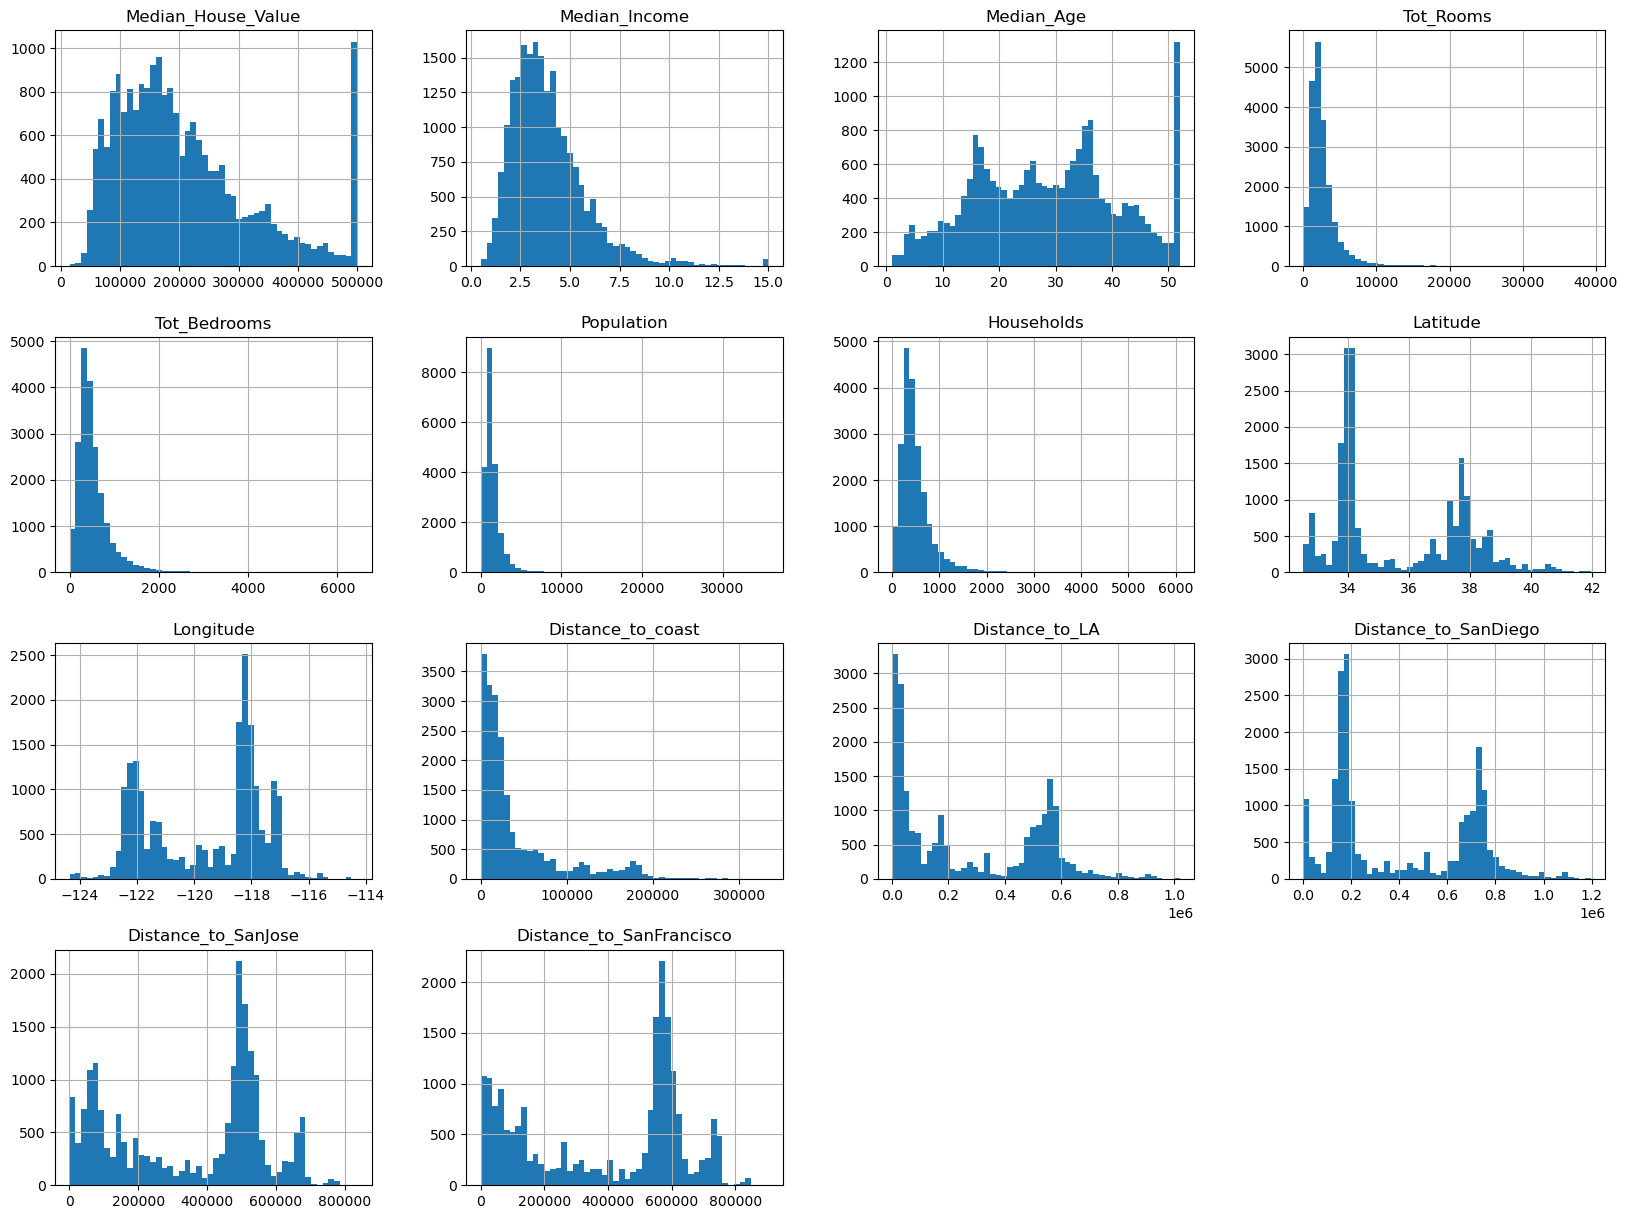

In [1]:
import pandas as pd

df = pd.read_csv("California_Houses.csv")
y = df["Median_House_Value"].values  # Actual output
X = df.drop(columns=["Median_House_Value"]).values  # Features
df.hist(bins=50, figsize=(20, 15))
total_len = len(df)

### SPLIT DATA INTO TRAIN / VALIDATION / TEST SETS


In [2]:
from sklearn.model_selection import train_test_split

# First split: 85% temp + 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.15,  # 15% of total data for testing
    random_state=42,  # The data is split exactly the same way every time  the code is run
    shuffle=True,  # Randomly shuffle data before splitting to avoid bias
)

# Second split: from the 85% temp, split 70/15 (train/valid)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp,
    y_temp,
    test_size=0.1765,  # 0.1765 × 0.85 = 0.15
    random_state=42,
    shuffle=True,
)

In [4]:
print("Shapes:", X_train.shape, X_valid.shape, X_test.shape)
print("Shapes:", y_train.shape, y_valid.shape, y_test.shape)

Shapes: (14447, 13) (3097, 13) (3096, 13)
Shapes: (14447,) (3097,) (3096,)


## Scaling Features

We use `StandardScaler` to scale the input features (`X`) so that they all have a mean of 0 and a standard deviation of 1. This helps models learn better and faster.

- The scaler is **fitted on the training set**.
- Then the same scaler is used to **transform the validation and test sets** to keep the scaling consistent.


In [5]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler_X = StandardScaler()

# Fit the scaler on the training data and transform it
# - 'fit' computes the mean and std of each feature from X_train
# - 'transform' applies the scaling using these computed values
X_train_scaled = scaler_X.fit_transform(X_train)
X_valid_scaled = scaler_X.transform(X_valid)
X_test_scaled = scaler_X.transform(X_test)

ADD BIAS TERM (COLUMN OF ONES) FOR INTERCEPT(B)


In [6]:
import numpy as np

# Add a bias term (column of ones) to the training set
# np.ones((X_train_scaled.shape[0], 1)) creates a column vector of ones
# np.c_ concatenates this column with the scaled features
X_train_scaled_bias = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_valid_scaled_bias = np.c_[np.ones((X_valid_scaled.shape[0], 1)), X_valid_scaled]
X_test_scaled_bias = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]

### CALCULATE WEIGHTS USING NORMAL EQUATION (ANALYTICAL SOLUTION)

$$\hat{w} = (X^T X)^{-1} X^T y$$


In [7]:
# Transpose of the training feature matrix (with bias)
XT = X_train_scaled_bias.T
# Mul X^T X
XXT = XT @ X_train_scaled_bias
# Compute (X^T X)^(-1)
XXT_inv = np.linalg.inv(XXT)
# Mul X^T y
XTy = XT @ y_train
w = XXT_inv @ XTy
# Reshape weights to a column vector
w = w.reshape(-1, 1)
# print(w)

In **linear regression**, the predicted output $\hat{Y}$ is calculated as:

$$
\hat{Y} = X \hat{w}
$$

- $X$ is the matrix of input features.
- $\hat{w}$ is the vector of learned weights (coefficients).
- $\hat{Y}$ is the predicted output.


### Prediction Function

The `predict` function calculates the predicted output for linear regression:


In [8]:
def predict(X, w):
    return X @ w

In [ ]:
y_train_pred = predict(X_train_scaled_bias, w)
y_valid_pred = predict(X_valid_scaled_bias, w)
y_test_pred = predict(X_test_scaled_bias, w)

## Evaluating the Model

We use two common metrics to evaluate regression models:

1. **Mean Squared Error (MSE)**  
   Measures the average squared difference between the actual and predicted values. Smaller values indicate better predictions.
2. **Mean Absolute Error (MAE)**  
   Measures the average absolute difference between the actual and predicted values. It is less sensitive to outliers than MSE


In [10]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# Calculate Mean Squared Error (MSE) for each dataset
train_mse = mean_squared_error(y_train, y_train_pred)
valid_mse = mean_squared_error(y_valid, y_valid_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# Calculate Mean Absolute Error (MAE) for each dataset
train_mae = mean_absolute_error(y_train, y_train_pred)
valid_mae = mean_absolute_error(y_valid, y_valid_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Create a DataFrame to display the results
mae_mse_scores = {
    "Dataset": ["Train", "Validation", "Test"],
    "MAE": [train_mae, valid_mae, test_mae],
    "MSE": [train_mse, valid_mse, test_mse],
}

print(pd.DataFrame(mae_mse_scores))

      Dataset           MAE           MSE
0       Train  49688.466093  4.698581e+09
1  Validation  49819.740713  4.603019e+09
2        Test  50744.913628  4.857042e+09


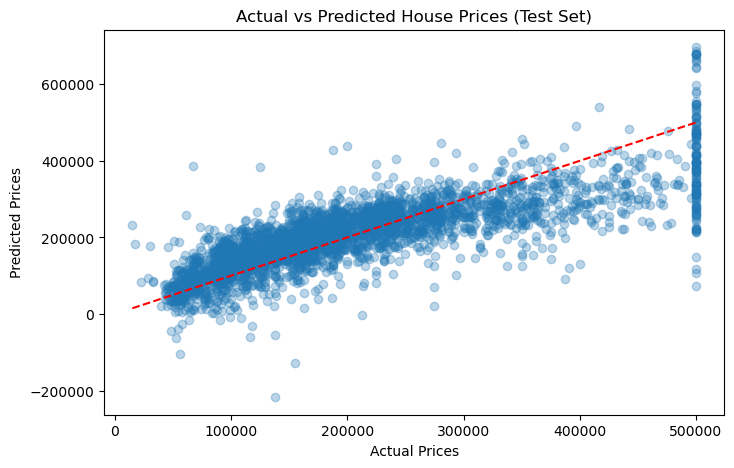

In [11]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted House Prices (Test Set)")
plt.plot(
    [y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--"
)  # perfect prediction line
plt.show()

# Gradient Descent

Is an iterative optimization algorithm used to minimize a cost function
J(w)
J(w), such as the Mean Squared Error in Linear Regression. Instead of solving for the weights analytically, GD updates the weights step by step in the direction that reduces the cost.
where $\alpha$ is the learning rate, $X$ is the feature matrix, $\mathbf{y}$ the targets, and $m$ the number of samples. The goal is to find optimal weights $\mathbf{w}$ that minimize $J(\mathbf{w})$.

$$
\nabla_{\mathbf{w}} J(\mathbf{w}) = \frac{1}{m} X^T (X \mathbf{w} - \mathbf{y})
$$

$$
\mathbf{w} := \mathbf{w} - \alpha \nabla_{\mathbf{w}} J(\mathbf{w})
$$


In [12]:
def gradient(X, y, theta):
    m = X.shape[0]
    h = predict(X, theta)
    grad = (1 / m) * X.T @ (h - y)
    return grad


def cost(X, y, theta):
    m = X.shape[0]
    h = predict(X, theta)
    J = (1 / (2 * m)) * np.sum((h - y) ** 2)
    return J

In [13]:
def create_mini_batches(X, y, batch_size):
    # Create mini-batches from the dataset
    mini_batches = []
    # stack X and y together for shuffling

    data = np.hstack((X, y))
    np.random.shuffle(data)
    n_minibatches = data.shape[0] // batch_size

    for i in range(n_minibatches + 1):
        mini_batch = data[i * batch_size : (i + 1) * batch_size, :]
        #
        X_mini = mini_batch[:, :-1]
        Y_mini = mini_batch[:, -1].reshape((-1, 1))
        mini_batches.append((X_mini, Y_mini))
    if data.shape[0] % batch_size != 0:
        mini_batch = data[i * batch_size :]
        X_mini = mini_batch[:, :-1]
        Y_mini = mini_batch[:, -1].reshape((-1, 1))
        mini_batches.append((X_mini, Y_mini))
    return mini_batches

In [14]:
def gradientDescent(X, y, learning_rate=0.001, batch_size=32):
    # Initialize parameters
    theta = np.zeros((X.shape[1], 1))
    error_list = []
    max_iters = 1000

    for itr in range(max_iters):
        mini_batches = create_mini_batches(X, y, batch_size)
        for X_mini, y_mini in mini_batches:
            theta = theta - learning_rate * gradient(X_mini, y_mini, theta)
            error_list.append(cost(X_mini, y_mini, theta))

    return theta, error_list

In [15]:
def tune_learning_rate(X, y, learning_rates, batch_size=1000):
    # Tune learning rate by trying different values and selecting the best one
    best_lr = None
    best_w = None
    best_cost = float("inf")
    lr_costs = {}

    for learning_rate in learning_rates:
        # calculate weights and cost for current learning rate
        w, costs = gradientDescent(
            X, y, learning_rate=learning_rate, batch_size=batch_size
        )
        final_cost = costs[-1] if len(costs) > 0 else float("inf")
        lr_costs[learning_rate] = final_cost

        if final_cost < best_cost:
            best_cost = final_cost
            best_lr = learning_rate
            best_w = w

    print(f"Best learning rate: {best_lr}")
    print(f"Final cost: {best_cost}")

    return best_w, best_lr, lr_costs


learning_rates = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]
theta_gd, best_lr, lr_costs = tune_learning_rate(
    X_train_scaled_bias,
    y_train.reshape(-1, 1),
    learning_rates=learning_rates,
    batch_size=7000,
)

Learning rate tuning completed
Best learning rate: 0.005
Final cost: 1836730881.5474298


Bias =  [206388.609412]
Coefficients =  [[ 74771.90882746]
 [ 11600.75674643]
 [-13540.6281659 ]
 [ 45515.49391174]
 [-44530.92084037]
 [ 17387.5465856 ]
 [-67727.53661832]
 [-61360.73811636]
 [-13057.57590639]
 [-31212.17864051]
 [ 33295.41060597]
 [ 22974.97135644]
 [-20507.53205766]]


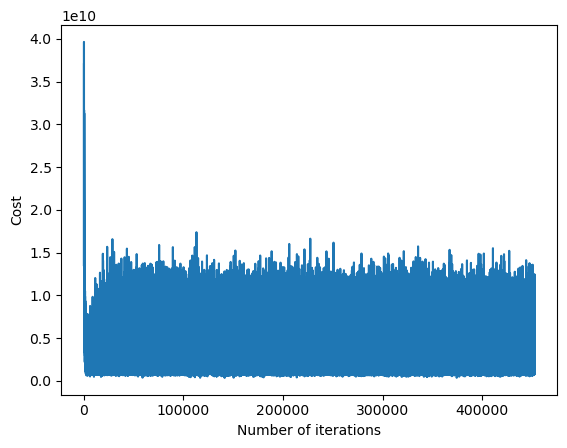

In [ ]:
y_2D_train = y_train.reshape(-1, 1)

# Run gradient descent with the best learning rate
theta, error_list = gradientDescent(X_train_scaled_bias, y_2D_train)
print("Bias = ", theta[0])
print("Coefficients = ", theta[1:])

plt.plot(error_list)
plt.xlabel("Number of iterations")
plt.ylabel("Cost")
plt.show()

In [17]:
# predictions of gradient descent model
y_train_pred_gd = X_train_scaled_bias @ theta_gd
y_val_pred_gd = X_valid_scaled_bias @ theta_gd
y_test_pred_gd = X_test_scaled_bias @ theta_gd

In [18]:
# mean squared error penalized for large errors more
linear_gd_mse_train = mean_squared_error(y_train, y_train_pred_gd)
linear_gd_mse_val = mean_squared_error(y_valid, y_val_pred_gd)
linear_gd_mse_test = mean_squared_error(y_test, y_test_pred_gd)
print(
    f"Linear Regression GD MSE: Train: {linear_gd_mse_train:.2f}, Val: {linear_gd_mse_val:.2f}, Test: {linear_gd_mse_test:.2f}"
)

# mean absolute error penalized for all errors equally
linear_gd_mae_train = mean_absolute_error(y_train, y_train_pred_gd)
linear_gd_mae_val = mean_absolute_error(y_valid, y_val_pred_gd)
linear_gd_mae_test = mean_absolute_error(y_test, y_test_pred_gd)

print(
    f"Linear Regression GD MAE: Train: {linear_gd_mae_train:.2f}, Val: {linear_gd_mae_val:.2f}, Test: {linear_gd_mae_test:.2f}"
)

Linear Regression GD MSE: Train: 4782189704.60, Val: 4733382984.78, Test: 4938026602.89
Linear Regression GD MAE: Train: 50597.68, Val: 50910.67, Test: 51702.77


# Linear regression scikit-learn


In [19]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()  # Create Linear Regression model
linear_model.fit(X_train_scaled, y_train)

y_train_pred_sklearn = linear_model.predict(X_train_scaled)
y_val_pred_sklearn = linear_model.predict(X_valid_scaled)
y_test_pred_sklearn = linear_model.predict(X_test_scaled)

## Evaluating the scikit-learn model


In [20]:
mse_train_sklearn = mean_squared_error(y_train, y_train_pred_sklearn)
mse_val_sklearn = mean_squared_error(y_valid, y_val_pred_sklearn)
mse_test_sklearn = mean_squared_error(y_test, y_test_pred_sklearn)

mae_train_sklearn = mean_absolute_error(y_train, y_train_pred_sklearn)
mae_val_sklearn = mean_absolute_error(y_valid, y_val_pred_sklearn)
mae_test_sklearn = mean_absolute_error(y_test, y_test_pred_sklearn)
mae_mse_scores_sklearn = {
    "Dataset": ["Train", "Validation", "Test"],
    "MAE": [mae_train_sklearn, mae_val_sklearn, mae_test_sklearn],
    "MSE": [mse_train_sklearn, mse_val_sklearn, mse_test_sklearn],
}


print(pd.DataFrame(mae_mse_scores_sklearn))

      Dataset           MAE           MSE
0       Train  49688.466093  4.698581e+09
1  Validation  49819.740713  4.603019e+09
2        Test  50744.913628  4.857042e+09


## Ridge Regression

Ridge regression shrinks the regression coefficients by imposing a penalty
on their size. The ridge coefficients minimize a penalized residual sum of squares,
$$RSS(λ)=(y-Xβ)^T(y-Xβ)+λβ^Tβ$$
the ridge solutions are easily seen to be
$$\hatβ^{ridge}=(X^TX+λI)^{-1}X^Ty$$


In [21]:
# Ridge Regression Implementation
def ridge_reg(X, Y, lamda):
    XXT_lamI = X.T @ X + lamda * np.eye(X.shape[1])
    w = np.linalg.inv(XXT_lamI) @ (X.T @ Y)
    return w

In [ ]:
# Testing different lambda values for Ridge Regression
lambdas = np.logspace(-3, 4, 100)

ridge_reg_mse = []
for lam in lambdas:
    w_ridge = ridge_reg(X_train_scaled_bias, y_train, lam)
    y_valid_pred_ridge = X_valid_scaled_bias @ w_ridge
    mse_ridge = mean_squared_error(y_valid, y_valid_pred_ridge)
    ridge_reg_mse.append(mse_ridge)

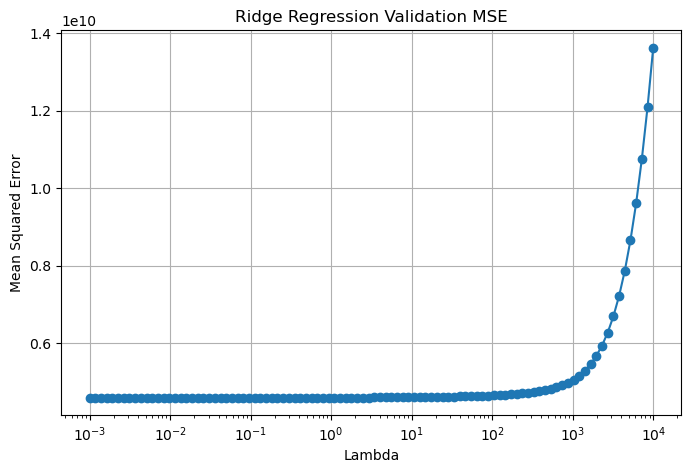

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(lambdas, ridge_reg_mse, marker="o")
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Mean Squared Error")
plt.title("Ridge Regression Validation MSE")
plt.grid()
plt.show()

In [46]:
# Finding the best lambda
best_lambda = lambdas[np.argmin(ridge_reg_mse)]
w_ridge_best = ridge_reg(X_train_scaled_bias, y_train, best_lambda)
y_test_pred_ridge = X_test_scaled_bias @ w_ridge_best
y_val_pred_ridge = X_valid_scaled_bias @ w_ridge_best
y_train_pred_ridge = X_train_scaled_bias @ w_ridge_best
print("Best lambda: ", best_lambda)

Best lambda:  0.001


In [47]:
# Calculating MSE and MAE for Ridge Regression
mse_train_ridge = mean_squared_error(y_train, y_train_pred_ridge)
mse_val_ridge = mean_squared_error(y_valid, y_val_pred_ridge)
mse_test_ridge = mean_squared_error(y_test, y_test_pred_ridge)

mae_train_ridge = mean_absolute_error(y_train, y_train_pred_ridge)
mae_val_ridge = mean_absolute_error(y_valid, y_val_pred_ridge)
mae_test_ridge = mean_absolute_error(y_test, y_test_pred_ridge)


mae_mse_scores_ridge = {
    "Dataset": ["Train", "Validation", "Test"],
    "MAE": [mae_train_ridge, mae_val_ridge, mae_test_ridge],
    "MSE": [mse_train_ridge, mse_val_ridge, mse_test_ridge],
}


print(pd.DataFrame(mae_mse_scores_ridge))

      Dataset           MAE           MSE
0       Train  49688.467386  4.698581e+09
1  Validation  49819.748665  4.603020e+09
2        Test  50744.917896  4.857042e+09


# Ridge Regression Using Scikit-learn


In [ ]:
from sklearn.linear_model import Ridge

lambdas = np.logspace(-3, 4, 100)
ridge_sklearn_mse = []

for l in lambdas:
    model = Ridge(alpha=l)
    model.fit(X_train_scaled_bias, y_train)
    y_val_pred = model.predict(X_valid_scaled_bias)
    ridge_sklearn_mse.append(mean_squared_error(y_valid, y_val_pred))

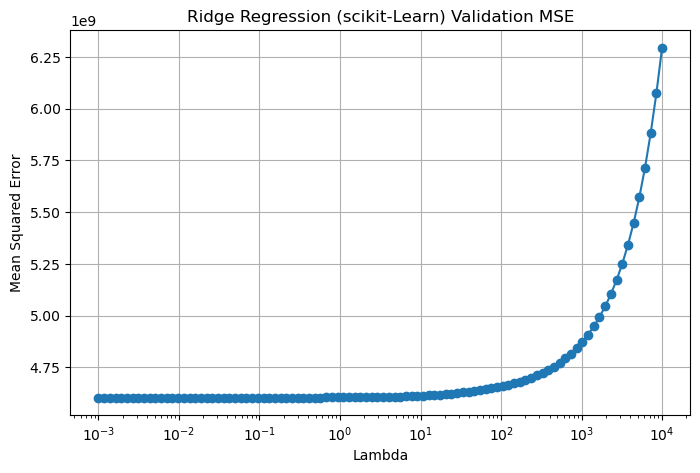

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(lambdas, ridge_sklearn_mse, marker="o")
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Mean Squared Error")
plt.title("Ridge Regression (scikit-Learn) Validation MSE")
plt.grid()
plt.show()

In [ ]:
best_lambda_sklearn = lambdas[np.argmin(ridge_sklearn_mse)]
ridge_model = Ridge(alpha=best_lambda_sklearn)
ridge_model.fit(X_train_scaled_bias, y_train)

In [30]:
# predictions using scikit-learn Ridge model
y_test_pred_ridge_sklearn = ridge_model.predict(X_test_scaled_bias)
y_val_pred_ridge_sklearn = ridge_model.predict(X_valid_scaled_bias)
y_train_pred_ridge_sklearn = ridge_model.predict(X_train_scaled_bias)

In [31]:
mse_ridge_train_scikit = mean_squared_error(y_train, y_train_pred_ridge_sklearn)
mse_ridge_val_scikit = mean_squared_error(y_valid, y_val_pred_ridge_sklearn)
mse_ridge_test_scikit = mean_squared_error(y_test, y_test_pred_ridge_sklearn)
mae_ridge_train_scikit = mean_absolute_error(y_train, y_train_pred_ridge_sklearn)
mae_ridge_val_scikit = mean_absolute_error(y_valid, y_val_pred_ridge_sklearn)
mae_ridge_test_scikit = mean_absolute_error(y_test, y_test_pred_ridge_sklearn)
print("Best lambda (Sklearn): ", best_lambda_sklearn)

mae_mse_scores_ridge_scikit = {
    "Dataset": ["Train", "Validation", "Test"],
    "MAE": [mae_ridge_train_scikit, mae_ridge_val_scikit, mae_ridge_test_scikit],
    "MSE": [mse_ridge_train_scikit, mse_ridge_val_scikit, mse_ridge_test_scikit],
}
print(pd.DataFrame(mae_mse_scores_ridge_scikit))

Best lambda (Sklearn):  0.001
      Dataset           MAE           MSE
0       Train  49688.469749  4.698581e+09
1  Validation  49819.750947  4.603020e+09
2        Test  50744.919916  4.857042e+09


# Lasso Regression Using Scikit-learn


In [32]:
from sklearn.linear_model import Lasso

lambdas = np.logspace(-3, 4, 100)
lasso_sklearn_mse = []

for l in lambdas:
    model = Lasso(alpha=l, max_iter=10000)
    model.fit(X_train_scaled_bias, y_train)
    y_val_pred = model.predict(X_valid_scaled_bias)
    lasso_sklearn_mse.append(mean_squared_error(y_valid, y_val_pred))

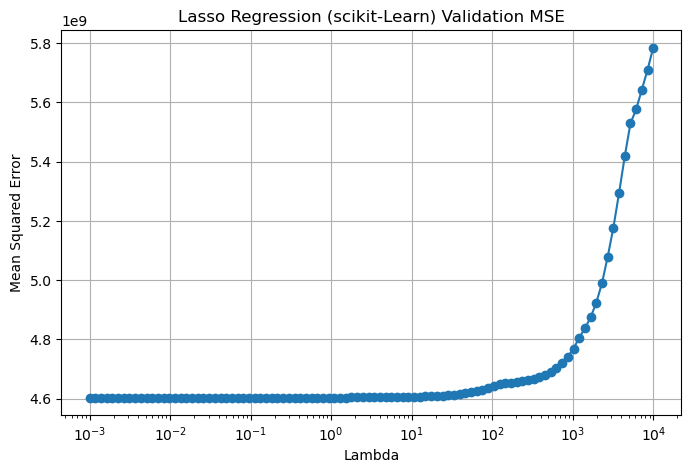

In [33]:
plt.figure(figsize=(8, 5))
plt.plot(lambdas, lasso_sklearn_mse, marker="o")
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Mean Squared Error")
plt.title("Lasso Regression (scikit-Learn) Validation MSE")
plt.grid()
plt.show()

In [35]:
best_lambda_Lasso = lambdas[np.argmin(lasso_sklearn_mse)]
Lasso_model = Lasso(alpha=best_lambda_Lasso, max_iter=10000)
Lasso_model.fit(X_train_scaled_bias, y_train)

Lasso(alpha=0.001, max_iter=10000)

In [ ]:
# predictions using scikit-learn Lasso model
y_test_pred_Lasso_sklearn = Lasso_model.predict(X_test_scaled_bias)
y_val_pred_Lasso_sklearn = Lasso_model.predict(X_valid_scaled_bias)
y_train_pred_Lasso_sklearn = Lasso_model.predict(X_train_scaled_bias)

# Analysing Models


In [ ]:
mse_Lasso_train_scikit = mean_squared_error(y_train, y_train_pred_Lasso_sklearn)
mse_Lasso_val_scikit = mean_squared_error(y_valid, y_val_pred_Lasso_sklearn)
mse_Lasso_test_scikit = mean_squared_error(y_test, y_test_pred_Lasso_sklearn)

mae_Lasso_train_scikit = mean_absolute_error(y_train, y_train_pred_Lasso_sklearn)
mae_Lasso_val_scikit = mean_absolute_error(y_valid, y_val_pred_Lasso_sklearn)
mae_Lasso_test_scikit = mean_absolute_error(y_test, y_test_pred_Lasso_sklearn)
print("Best lambda (Sklearn - Lasso): ", best_lambda_Lasso)

mae_mse_scores_ridge_scikit = {
    "Dataset": ["Train", "Validation", "Test"],
    "MAE": [mae_Lasso_train_scikit, mae_Lasso_val_scikit, mae_Lasso_test_scikit],
    "MSE": [mse_Lasso_train_scikit, mse_Lasso_val_scikit, mse_Lasso_test_scikit],
}
print(pd.DataFrame(mae_mse_scores_ridge_scikit))

Best lambda (Sklearn - Lasso):  0.001
      Dataset           MAE           MSE
0       Train  49688.466788  4.698581e+09
1  Validation  49819.743349  4.603019e+09
2        Test  50744.914980  4.857042e+09


In [39]:
comparison = pd.DataFrame(
    {
        "Train MSE": [
            linear_gd_mse_train,
            train_mse,
            mse_train_ridge,
            mse_ridge_train_scikit,
            mse_Lasso_train_scikit,
        ],
        "Validation MSE": [
            linear_gd_mse_val,
            valid_mse,
            mse_val_ridge,
            mse_ridge_val_scikit,
            mse_Lasso_val_scikit,
        ],
        "Test MSE": [
            linear_gd_mse_test,
            test_mse,
            mse_test_ridge,
            mse_ridge_test_scikit,
            mse_Lasso_test_scikit,
        ],
        "Train MAE": [
            linear_gd_mae_train,
            train_mae,
            mae_train_ridge,
            mae_ridge_train_scikit,
            mae_Lasso_train_scikit,
        ],
        "Validation MAE": [
            linear_gd_mae_val,
            valid_mae,
            mae_val_ridge,
            mae_ridge_val_scikit,
            mae_Lasso_val_scikit,
        ],
        "Test MAE": [
            linear_gd_mae_test,
            test_mae,
            mae_test_ridge,
            mae_ridge_test_scikit,
            mae_Lasso_test_scikit,
        ],
    },
    index=[
        "Gradient Descent",
        "Normal Equation",
        "Ridge Normal Equation",
        "Ridge (scikit-Learn)",
        "Lasso",
    ],
)

print("Linear Regression ")
display(comparison.round(4))

Linear Regression 


,Train MSE,Validation MSE,Test MSE,Train MAE,Validation MAE,Test MAE
Gradient Descent,4.782190e+09,4.733383e+09,4.938027e+09,50597.6751,50910.6741,51702.7658
Normal Equation,4.698581e+09,4.603019e+09,4.857042e+09,49688.4661,49819.7407,50744.9136
Ridge Normal Equation,4.698581e+09,4.603020e+09,4.857042e+09,49688.4674,49819.7487,50744.9179
Ridge (scikit-Learn),4.698581e+09,4.603020e+09,4.857042e+09,49688.4697,49819.7509,50744.9199
Lasso,4.698581e+09,4.603019e+09,4.857042e+09,49688.4668,49819.7433,50744.9150


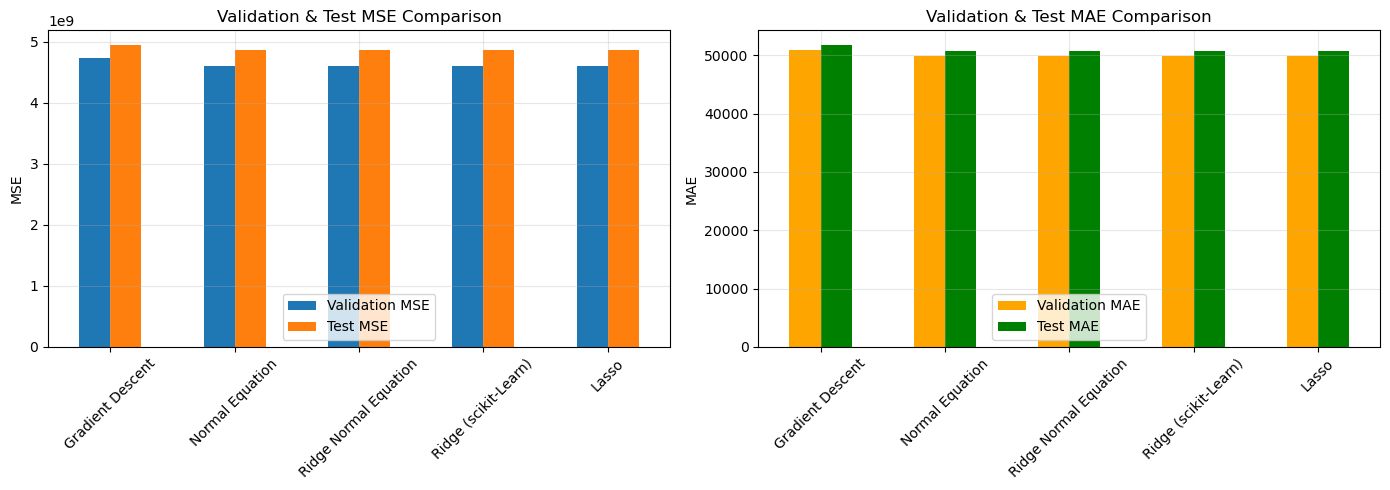

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot for Validation & Test MSE
comparison[["Validation MSE", "Test MSE"]].plot(
    kind="bar", ax=axes[0], title="Validation & Test MSE Comparison"
)
axes[0].set_ylabel("MSE")
axes[0].grid(True, alpha=0.3)
axes[0].set_xticklabels(comparison.index, rotation=45)

comparison[["Validation MAE", "Test MAE"]].plot(
    kind="bar",
    ax=axes[1],
    title="Validation & Test MAE Comparison",
    color=["orange", "green"],
)
axes[1].set_ylabel("MAE")
axes[1].grid(True, alpha=0.3)
axes[1].set_xticklabels(comparison.index, rotation=45)

plt.tight_layout()
plt.show()

In [48]:
from sklearn.metrics import r2_score


r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_valid, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

r2_train_ridge = r2_score(y_train, y_train_pred_ridge)
r2_val_ridge_ = r2_score(y_valid, y_val_pred_ridge)
r2_test_ridge = r2_score(y_test, y_test_pred_ridge)

r2_train_gd = r2_score(y_train, y_train_pred_gd)
r2_val_gd = r2_score(y_valid, y_val_pred_gd)
r2_test_gd = r2_score(y_test, y_test_pred_gd)


r2_train_sklearn = r2_score(y_train, y_train_pred_sklearn)
r2_val_sklearn = r2_score(y_valid, y_val_pred_sklearn)
r2_test_sklearn = r2_score(y_test, y_test_pred_sklearn)


r2_train_ridge_sklearn = r2_score(y_train, y_train_pred_ridge_sklearn)
r2_val_ridge_sklearn = r2_score(y_valid, y_val_pred_ridge_sklearn)
r2_test_ridge_sklearn = r2_score(y_test, y_test_pred_ridge_sklearn)

r2_train_lasso_sklearn = r2_score(y_train, y_train_pred_Lasso_sklearn)
r2_val_lasso_sklearn = r2_score(y_valid, y_val_pred_Lasso_sklearn)
r2_test_lasso_sklearn = r2_score(y_test, y_test_pred_Lasso_sklearn)

R² Score Comparison Across All Models


,Train R²,Validation R²,Test R²
Linear (Normal Eq),0.6479,0.5676,0.6294
Ridge (Normal Eq),0.6479,0.6559,0.6294
Linear (GD),0.6417,0.6462,0.6232
Linear (Sklearn),0.6479,0.6559,0.6294
Ridge (Sklearn),0.6479,0.6559,0.6294
Lasso (Sklearn),0.6479,0.6559,0.6294


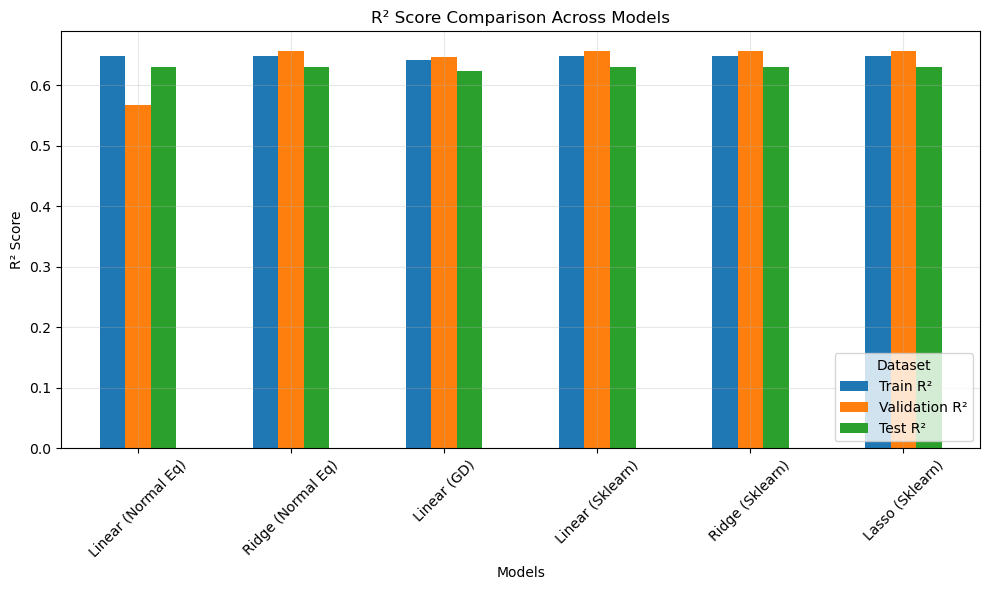

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

r2_scores = {
    "Linear (Normal Eq)": [r2_train, r2_val, r2_test],
    "Ridge (Normal Eq)": [r2_train_ridge, r2_val_ridge_, r2_test_ridge],
    "Linear (GD)": [r2_train_gd, r2_val_gd, r2_test_gd],
    "Linear (Sklearn)": [r2_train_sklearn, r2_val_sklearn, r2_test_sklearn],
    "Ridge (Sklearn)": [
        r2_train_ridge_sklearn,
        r2_val_ridge_sklearn,
        r2_test_ridge_sklearn,
    ],
    "Lasso (Sklearn)": [
        r2_train_lasso_sklearn,
        r2_val_lasso_sklearn,
        r2_test_lasso_sklearn,
    ],
}

r2_comparison = pd.DataFrame(
    r2_scores, index=["Train R²", "Validation R²", "Test R²"]
).T

print("R² Score Comparison Across All Models")
display(r2_comparison.round(4))

# Plotting
r2_comparison.plot(kind="bar", figsize=(10, 6))
plt.title("R² Score Comparison Across Models")
plt.ylabel("R² Score")
plt.xlabel("Models")
plt.grid(True, alpha=0.3)
plt.legend(title="Dataset", loc="lower right")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- All models achieve R² scores between ~0.55 and 0.67 across datasets.
- No dramatic difference between models.
- All models show MSE ≈ 4.7–4.9 × 10⁹ and MAE ≈ 49,000–51,000, which are quite close.
- The Train, Validation, and Test metrics are very close → no overfitting.
